# Demo *Algoritmo de Shor* con Qiskit

Documento elaborado por: *Sergio Tello*

---

Vamos a ilustrar el algoritmo de Shor factorizando el número $N = 15$. Tomaremos $a = 13$. Observemos que nuestros números no tienen factores comunes.

<img src='shor_circuito.png' width='850'>

Podemos ver en la siguiente tabla el periodo de la función $f_{13, 15}(x) = 13^x\ \mathrm{mod}\ 15$:

x | 13^x | 13^x mod 15 
:-|-:|:-:
0 | 1           | 1
1 | 13          | 13
2 | 169         | 4
3 | 2197        | 7
4 | 28561       | 1
5 | 371293      | 13
6 | 4826809     | 4
7 | 62748517    | 7
8 | 815730721   | 1
9 | 10604499373 | 13
10| 137858491849| 4

Veamos si el algoritmo de Shor nos da este mismo resultado. 

La tabla de arriba pero en binario

x | x (binario) | 13^x mod 15 | 13^x mod 15 (binario) 
:-|-:|:-:| :-:
0 | 0000 | 1  | 0001
1 | 0001 | 13 | 1101
2 | 0010 | 4  | 0100
3 | 0011 | 7  | 0111
4 | 0100 | 1  | 0001
5 | 0101 | 13 | 1101
6 | 0110 | 4  | 0100
7 | 0111 | 7  | 0111
8 | 1000 | 1  | 0001
9 | 1001 | 13 | 1101
10| 1010 | 4  | 0100
11| 1011 | 7  | 0111
12| 1100 | 1  | 0001
13| 1101 | 13 | 1101
14| 1110 | 4  | 0100
15| 1111 | 7  | 0111

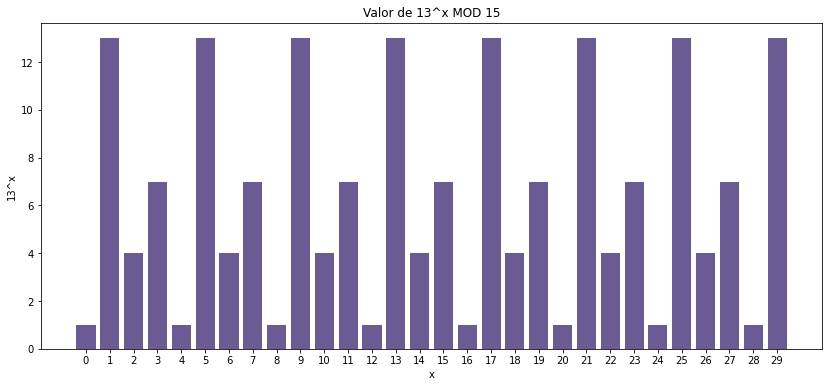

In [1]:
%run periodo_15_13.py

## 1. Multiplicación por $13$ módulo $15$

Queremos construir una compuerta cuántica a la que le ingresemos un entero $n$ hasta $15$ (en binario) y nos devuelva como estado final un entero (en binario) correspondiente al valor $13n$ módulo $15$.  

Veamos la siguiente tabla de multiplicación por $13$ módulo 15:

n | n (binario) | 13n | 13n mod 15 | 13n mod 15 (binario)
:-|:-:|:-: | :-: | :-: 
0 | 0000 | 0    | 0  | 0000 = 1111 | 
1 | 0001 | 13   | 13 | 1101 |
2 | 0010 | 26   | 11 | 1011 |
3 | 0011 | 39   | 9  | 1001 |
4 | 0100 | 52   | 7  | 0111 |
5 | 0101 | 65   | 5  | 0101 |
6 | 0110 | 78   | 3  | 0011 |
7 | 0111 | 91   | 1  | 0001 |
8 | 1000 | 104  | 14 | 1110 | 
9 | 1001 | 117  | 12 | 1100 |
10| 1010 | 130  | 10 | 1010 |
11| 1011 | 143  | 8  | 1000 |
12| 1100 | 156  | 6  | 0110 |
13| 1101 | 169  | 4  | 0100 |
14| 1110 | 182  | 2  | 0010 |
15| 1111 | 195  | 0  | 0000 |


Nota cómo el siguiente patrón se da para todas las entradas de la tabla:

<img src='por13mod15.png' width='200'>

Esto significa que multiplicar por $13$ módulo $15$ en binario se reduce a permutar los bits y negarlos. Esto nos permitirá construir la compuerta de multiplicación de forma muy sencilla y sin usar qubits auxiliares.

In [2]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt

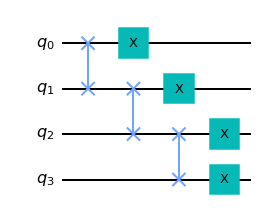

In [3]:
mult_13 = QuantumCircuit(4)
mult_13.swap(0, 1)
mult_13.swap(1, 2)
mult_13.swap(2, 3)
mult_13.x([0, 1, 2, 3])
mult_13.draw(output='mpl')

In [4]:
m_13 = mult_13.to_gate()
m_13.name = '*13_mod_15'

Probemos nuestra nueva compuerta tabulando algún valor particular en un circuito y midiendo el estado final:

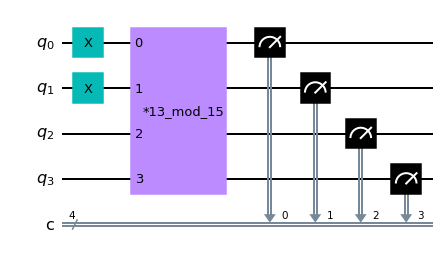

In [33]:
tab = QuantumCircuit(4, 4)
# Inicializar aquí con el número a multiplicar por 13 (por ejemplo, 8)
tab.x(0)
tab.x(1)
#####
tab.append(m_13, [0, 1, 2, 3])
tab.measure([0, 1, 2, 3], [0, 1, 2, 3])
tab.draw(output='mpl')

In [31]:
simulador = Aer.get_backend('qasm_simulator')

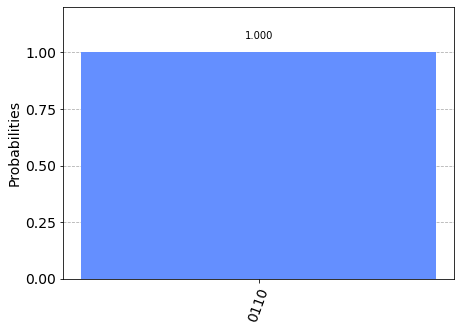

In [34]:
conteos = execute(tab, backend=simulador).result().get_counts()
plot_histogram(conteos)

¡Nuestra compuerta funciona perfectamente!

## 2. Calculando las potencias de $13$ módulo $15$

Ahora la vamos a usar como punto de partida para construir un circuito cuántico que nos permita calcular las potencias de 13 módulo 15, es decir, $13^x\ \mathrm{mod}\ 15$.

Para esto usaremos la potenciación binaria. ¿Qué es esto? 

Lo explicaremos con el siguiente ejemplo:

$$13^{45} = 13^{1 + 4 + 8 + 32} = 13^1 \times 13^4 \times 13^8 \times 13^{32}$$

Fíjate que puedes calcular el valor de 13 elevado a cualquier potencia sólamente evaluando 13 elevado a las potencias de $2$ y haciendo multiplicaciones.

Es por esta razón que en nuestro circuito para el algoritmo de Shor tenemos las compuertas de multiplicación por 13 ($a$) elevado a las potencias de $2$ y es también por esta razón que son compuertas controladas. 

<img src='expo.gif' width='500'>

Para construir una compuerta controlada en Qiskit, usamos el método ```.control()```.

In [8]:
cm13 = m_13.control()

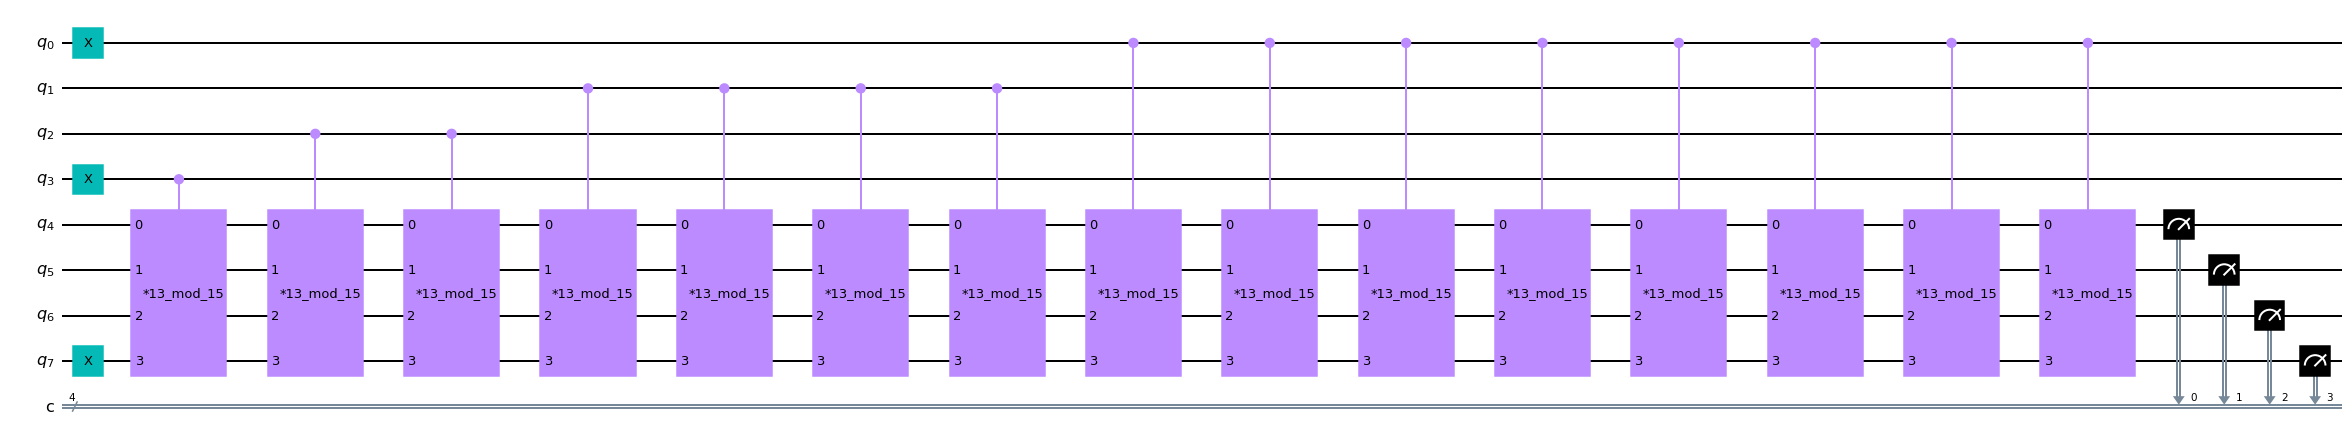

In [38]:
expo = QuantumCircuit(8, 4)

# Inicializa con el valor del exponente x para el que quieres cualcular 13^x. Por ejemplo, 6
expo.x(0)
#expo.x(2)
expo.x(3)

expo.x(7)

expo.append(cm13, [3, 4, 5, 6, 7])

expo.append(cm13, [2, 4, 5, 6, 7])
expo.append(cm13, [2, 4, 5, 6, 7])

expo.append(cm13, [1, 4, 5, 6, 7])
expo.append(cm13, [1, 4, 5, 6, 7])
expo.append(cm13, [1, 4, 5, 6, 7])
expo.append(cm13, [1, 4, 5, 6, 7])

expo.append(cm13, [0, 4, 5, 6, 7])
expo.append(cm13, [0, 4, 5, 6, 7])
expo.append(cm13, [0, 4, 5, 6, 7])
expo.append(cm13, [0, 4, 5, 6, 7])
expo.append(cm13, [0, 4, 5, 6, 7])
expo.append(cm13, [0, 4, 5, 6, 7])
expo.append(cm13, [0, 4, 5, 6, 7])
expo.append(cm13, [0, 4, 5, 6, 7])

expo.measure([4, 5, 6, 7], [0, 1, 2, 3])
expo.draw(output='mpl', fold=-1)

Comprobemos el resultado (ten en cuenta la primera tabla)

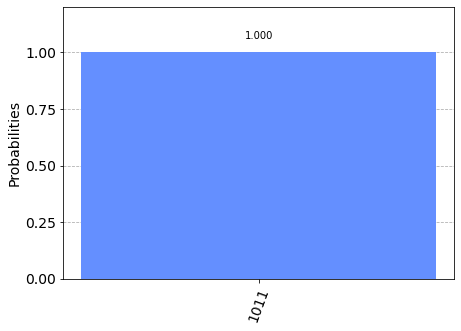

In [39]:
conteos = execute(expo, backend=simulador).result().get_counts()
plot_histogram(conteos)

Muy bien, ahora pasemos a la transformada cuántica de Fourier.

## 3. Transformada cuántica de Fourier (QFT)

La transformada cuántica de Fourier no es otra cosa que la implementación mediante compuertas cuánticas de la transformada discreta de Fourier (DFT) que ya conocemos. Por ejemplo, la DFT de $4 \times 4$ es la matriz:

$$\frac{1}{\sqrt{4}}
\begin{bmatrix} 
    \omega^{0\times0} & \omega^{0\times1} & \omega^{0\times2} & \omega^{0\times3} \\
    \omega^{1\times0} & \omega^{1\times1} & \omega^{1\times2} & \omega^{1\times3} \\
    \omega^{2\times0} & \omega^{2\times1} & \omega^{2\times2} & \omega^{2\times3} \\
    \omega^{3\times0} & \omega^{3\times1} & \omega^{3\times2} & \omega^{3\times3} \\
\end{bmatrix}$$

Donde $\omega = e^{i  \cdot 2\pi/4} = e^{i \cdot \pi/2} = i$.

Reemplazando y simplificando:

$$\frac{1}{2}
\begin{bmatrix} 
    1 & 1 & 1 & 1 \\
    1 & i & -1&-i \\
    1 &-1 & 1 & -1 \\
    1 & -i & -1 & i
\end{bmatrix}$$

Esta matriz es **unitaria** (es decir, $M \star M^{\dagger} = I$) y, por lo tanto, es una compuerta cuántica válida que actúa sobre 2 qubits.

Aquí podemos ver una representación gráfica de las primeras matrices para la DFT que tienen tamaño una potencia de 2:

<img src='dft_matriz_color_a.png'>

El circuito cuántico correspondiente es el siguiente:

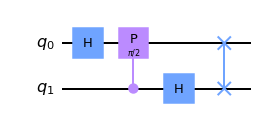

In [11]:
qft2 = QuantumCircuit(2)

qft2.h(0)
qft2.cp(np.pi/2, 1, 0)
qft2.h(1)
qft2.swap(0, 1)
qft2.draw(output='mpl')

Donde 

$$P(\theta) = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\theta} \end{bmatrix}$$

Es la matriz de rotación sobre el eje $z$ o la matriz/dinámica de cambio de fase.

Podemos comprobarlo haciendo la multiplicación de matrices.

In [40]:
H = 1/np.sqrt(2) * np.array([
    [1, 1],
    [1, -1]
])

I = np.array([
    [1, 0],
    [0, 1]
])

CP_pi_2 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1j]
])

SWAP = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

In [41]:
matriz_circuito_qft = SWAP @ np.kron(I, H) @ CP_pi_2 @ np.kron(H, I)

print(matriz_circuito_qft)

[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. +0.5j -0.5+0.j   0. -0.5j]
 [ 0.5+0.j  -0.5+0.j   0.5+0.j  -0.5+0.j ]
 [ 0.5+0.j   0. -0.5j -0.5+0.j   0. +0.5j]]


El operador ```@``` es una alternativa simbólica para la multiplicación de matrices que también se puede hacer con ```np.matmul```. En efecto, vemos que la matriz del circuito QFT y la matriz de la DFT son iguales.

### 3.1. Aplicaciones de la transformada de Fourier

Pero, ¿para qué servía la transformada de Fourier?

Nos ayudaba a identificar el periodo de vectores que lo tuvieran. Recordemos:

In [42]:
N = 8

dft = np.zeros((N, N), dtype=complex) 
w = np.exp(1j*2*np.pi/N)

for i in range(len(dft)):
    for j in range(len(dft)):
        dft[i][j] = np.exp(1j*(2*np.pi/N)*i*j)
print(dft)

[[ 1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
   1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
   1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
   1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j]
 [ 1.00000000e+00+0.00000000e+00j  7.07106781e-01+7.07106781e-01j
   6.12323400e-17+1.00000000e+00j -7.07106781e-01+7.07106781e-01j
  -1.00000000e+00+1.22464680e-16j -7.07106781e-01-7.07106781e-01j
  -1.83697020e-16-1.00000000e+00j  7.07106781e-01-7.07106781e-01j]
 [ 1.00000000e+00+0.00000000e+00j  6.12323400e-17+1.00000000e+00j
  -1.00000000e+00+1.22464680e-16j -1.83697020e-16-1.00000000e+00j
   1.00000000e+00-2.44929360e-16j  3.06161700e-16+1.00000000e+00j
  -1.00000000e+00+3.67394040e-16j -4.28626380e-16-1.00000000e+00j]
 [ 1.00000000e+00+0.00000000e+00j -7.07106781e-01+7.07106781e-01j
  -1.83697020e-16-1.00000000e+00j  7.07106781e-01+7.07106781e-01j
  -1.00000000e+00+3.67394040e-16j  7.07106781e-01-7.07106781e-01j
   5.51

In [15]:
v = np.zeros((N, 1), dtype=complex)
v[0][0] = 0
v[1][0] = 1
v[2][0] = 0
v[3][0] = 0
v[4][0] = 0
v[5][0] = 1
v[6][0] = 0
v[7][0] = 0

In [43]:
resultado = np.matmul(dft, v)
print(resultado)

[[ 2.00000000e+00+0.00000000e+00j]
 [-1.11022302e-16+0.00000000e+00j]
 [ 3.67394040e-16+2.00000000e+00j]
 [-8.88178420e-16-8.88178420e-16j]
 [-2.00000000e+00+7.34788079e-16j]
 [-2.22044605e-16+1.11022302e-16j]
 [-2.87853896e-15-2.00000000e+00j]
 [ 1.22124533e-15+1.22124533e-15j]]


In [44]:
x = np.zeros((N, 1))

for i in range(len(x)):
    x[i][0] = np.abs(resultado[i][0])**2

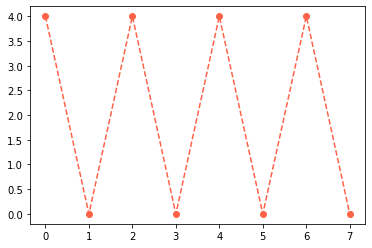

In [45]:
plt.plot(x, 'tomato', marker='o', linestyle='dashed')

Si el vector tiene tamaño $T$ los picos en este espectrograma se presentarán en los múltiplos de $T/p$ donde $p$ es el periodo (tamaño del bloque que se repite). ($T/p$ sería el número de bloques).

Ahora este mismo experimento pero con el circuito cuántico:

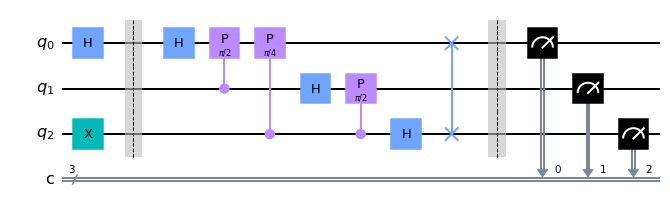

In [19]:
qft3 = QuantumCircuit(3, 3)

## Inicializamos en estado |+01> ~ (0 1 0 0 0 1 0 0) 2 bloques de tamaño 4 (perido = 4)
qft3.h(0)
qft3.x(2)


qft3.barrier()

qft3.h(0)
qft3.cp(np.pi/2, 1, 0)
qft3.cp(np.pi/4, 2, 0)

qft3.h(1)
qft3.cp(np.pi/2, 2, 1)

qft3.h(2)

qft3.swap(0, 2)

qft3.barrier()

qft3.measure([0, 1, 2], [0, 1, 2])

qft3.draw(output='mpl')

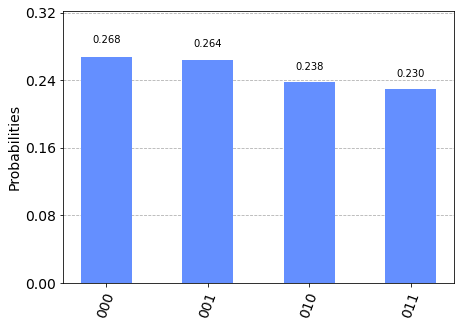

In [20]:
conteos = execute(qft3, backend=simulador, shots=1000).result().get_counts()
plot_histogram(conteos)

## 4. Algoritmo de Shor

Primero construiremos la QFT para 4 qubits.

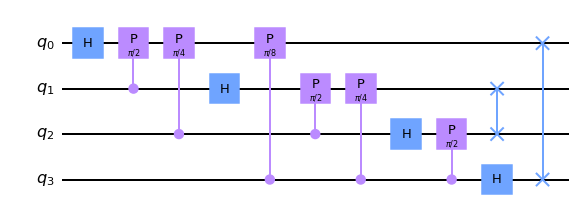

In [48]:
qft4 = QuantumCircuit(4)

qft4.h(0)
qft4.cp(np.pi/2, 1, 0)
qft4.cp(np.pi/4, 2, 0)
qft4.cp(np.pi/8, 3, 0)

#qft4.barrier()

qft4.h(1)
qft4.cp(np.pi/2, 2, 1)
qft4.cp(np.pi/4, 3, 1)

#qft4.barrier()

qft4.h(2)
qft4.cp(np.pi/2, 3, 2)

#qft4.barrier()

qft4.h(3)

#qft4.barrier()

qft4.swap(1, 2)
qft4.swap(0, 3)

qft4.draw(output='mpl')

In [49]:
qft_4 = qft4.to_gate()
qft_4.name = '_____QFT_____'

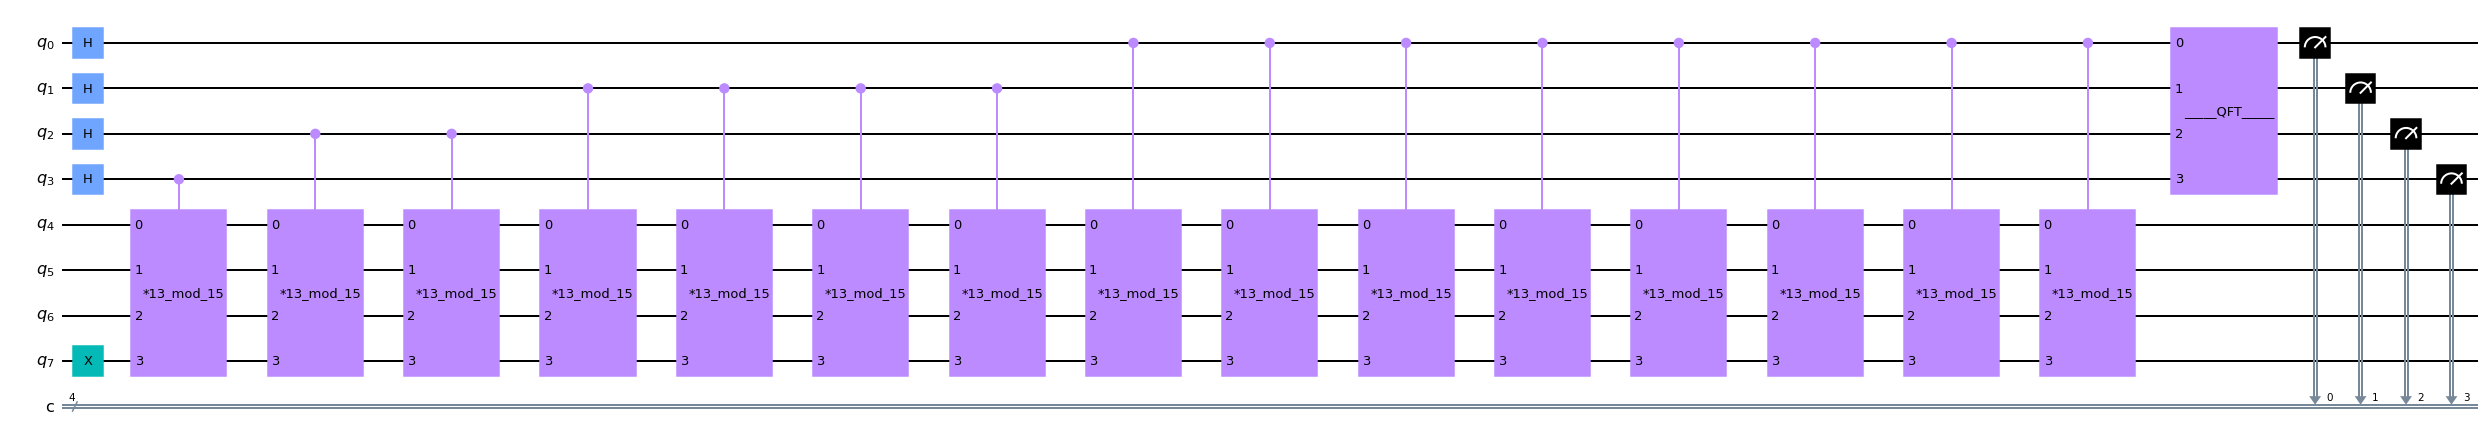

In [50]:
shor = QuantumCircuit(8, 4)

shor.h([0, 1, 2, 3])

shor.x(7)

shor.append(cm13, [3, 4, 5, 6, 7])

shor.append(cm13, [2, 4, 5, 6, 7])
shor.append(cm13, [2, 4, 5, 6, 7])

shor.append(cm13, [1, 4, 5, 6, 7])
shor.append(cm13, [1, 4, 5, 6, 7])
shor.append(cm13, [1, 4, 5, 6, 7])
shor.append(cm13, [1, 4, 5, 6, 7])

shor.append(cm13, [0, 4, 5, 6, 7])
shor.append(cm13, [0, 4, 5, 6, 7])
shor.append(cm13, [0, 4, 5, 6, 7])
shor.append(cm13, [0, 4, 5, 6, 7])
shor.append(cm13, [0, 4, 5, 6, 7])
shor.append(cm13, [0, 4, 5, 6, 7])
shor.append(cm13, [0, 4, 5, 6, 7])
shor.append(cm13, [0, 4, 5, 6, 7])

shor.append(qft_4, [0, 1, 2, 3])

shor.measure([0, 1, 2, 3], [0, 1, 2, 3])

shor.draw(output='mpl', fold=-1)

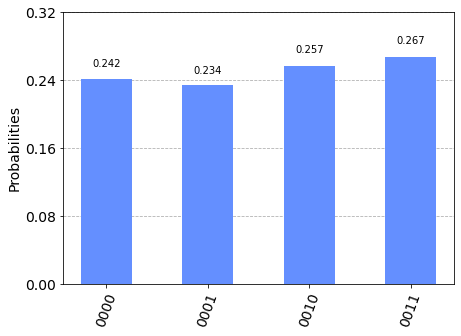

In [51]:
conteos = execute(shor, backend=simulador, shots=1000).result().get_counts()
plot_histogram(conteos)

*Recuerda:* Si el vector tiene tamaño $T$ los picos en este espectrograma se presentarán en los múltiplos de $T/p$ donde $p$ es el periodo (tamaño del bloque que se repite). ($T/p$ sería el número de bloques).


El espectrograma obtenido tiene picos en: $0, 8, 4$ y $12$. Como estamos midiendo 4 qubits, el tamaño del vector de estado es $T = 2^4 = 16$. Analicemos los posibles valores de $T/p$:

Si $p = 2$, entonces $T/p = 8$ pero esto no es posible ya que $4$ no puede ser múltiplo de $8$.

Si $p = 4$, entonces $T/p = 4$ lo cual es consistente.

Si $p = 8$, entonces $T/p = 2$ lo cual es consistente.

El periodo de nuestra función es $p = 4$.

Es decir, cuando se divide $13^4$ entre $15$ obtenemos como residuo $1$. Numéricamente:

$$\frac{13^{4} - 1}{15}$$

es una división exacta.

* Factorizamos el numerador usando que es una *diferencia de cuadrados*:

$$\frac{(13^2 - 1)(13^2 + 1)}{15}$$

* Calculamos el valor de cada paréntesis:

$$\frac{(168)(170)}{15}$$

Para encontrar los factores de 15 hallamos el mayor factor común entre cada uno de los números y 15:

In [52]:
#Factor común más grande entre dos números (Algoritmo de Euclides) o máximo común divisor.
def mayor_factor_comun(a, b):
    if b == 0:
        return a
    else:
        print(a, '=', b, '*', a//b, '+', a % b)
        return mayor_factor_comun(b, a % b)

In [53]:
mayor_factor_comun(168, 15)

168 = 15 * 11 + 3
15 = 3 * 5 + 0


3

In [54]:
mayor_factor_comun(170, 15)

170 = 15 * 11 + 5
15 = 5 * 3 + 0


5

*Nota:*

Si hubiéramos tomado $p = 8$ el proceso habría sido el siguiente:

Tendríamos que $13^8$ en congruente con 1 módulo 15, es decir, cuando se divide $13^8$ entre $15$ obtenemos como residuo $1$. Numéricamente:

$$\frac{13^{8} - 1}{15}$$

es una división exacta.

* Factorizamos el numerador usando que es una *diferencia de cuadrados*:

$$\frac{(13^4 - 1)(13^4 + 1)}{15}$$

* Calculamos el valor de cada paréntesis:

$$\frac{(28560)(28562)}{15}$$

Para encontrar los factores de 15 hallamos el mayor factor común entre cada uno de los números y 15:

In [28]:
mayor_factor_comun(28560, 15)

28560 = 15 * 1904 + 0


15

In [29]:
mayor_factor_comun(28562, 15)

28562 = 15 * 1904 + 2
15 = 2 * 7 + 1
2 = 1 * 2 + 0


1

Aparentemente, hemos "fallado", pues no obtuvimos 2 factores no triviales de nuestro número 15. Sin embargo, si observamos más de cerca, hemos obtenido que $15$ es factor de todo el primer paréntesis: $(13^4 - 1)$.

Es decir:

$$ 13^4 - 1 \equiv 0 \mod 15$$

Lo que equivale a:

$$ 13^4 \equiv 1 \mod 15$$

Y desde este punto podríamos plantear que:

Cuando se divide $13^4$ entre $15$ obtenemos como residuo $1$. Numéricamente:

$$\frac{13^{4} - 1}{15}$$

es una división exacta... Lo cual ya analizamos arriba y nos llevó a la factorización buscada.